In [2]:
!pip3 install opencv-python

In [6]:
!pip3 install moviepy

  Using cached moviepy-1.0.3-py3-none-any.whl
  Using cached decorator-4.4.2-py2.py3-none-any.whl (9.2 kB)
  Using cached proglog-0.1.10-py3-none-any.whl (6.1 kB)
  Using cached imageio_ffmpeg-0.4.7-py3-none-win_amd64.whl (22.6 MB)
  Attempting uninstall: decorator
    Found existing installation: decorator 5.1.0
    Uninstalling decorator-5.1.0:
      Successfully uninstalled decorator-5.1.0


In [2]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from sklearn.model_selection import train_test_split
from scipy.ndimage import label
from moviepy.editor import VideoFileClip
from collections import deque
import pickle
import os
import queue

In [17]:

# Define a function to return some characteristics of the dataset
def data_look(car_list, notcar_list):
    data_dict = {}
    # Define a key in data_dict "n_cars" and store the number of car images
    data_dict["n_cars"] = len(car_list)
    # Define a key "n_notcars" and store the number of notcar images
    data_dict["n_notcars"] = len(notcar_list)
    # Read in a test image, either car or notcar
    car_img = mpimg.imread(car_list[0])
    # Define a key "image_shape" and store the test image shape 3-tuple
    data_dict["image_shape"] = car_img.shape
    # Define a key "data_type" and store the data type of the test image.
    data_dict["data_type"] = car_img.dtype
    # Return data_dict
    return data_dict

def visualize_images(input_images, num_cols, figure_name, cmap = None):
    "Shows input images by stacking them in num_cols columns"
    fig, axes = plt.subplots((int)((len(input_images) + 1) /num_cols), num_cols, figsize=(24, 20))

    fig = plt.gcf()
    fig.canvas.set_window_title(figure_name)
    
    print(figure_name)
    
    for ax, image in zip(axes.flat, input_images):
        if(cmap == "gray" or cmap == 'hot'):
            ax.imshow(image, cmap=cmap)
        elif(image.shape[2]==1):
            ax.imshow(image[:,:,0], cmap = cmap)
        else:
            ax.imshow(image, cmap=cmap)

    plt.show()



In [4]:
import zipfile as zf
files = zf.ZipFile("veh.zip", 'r')
files.extractall('dir')
files.close()


# Read cars and not-cars images

# Data folders
vehicles_dir = 'dir/vehicles/'
non_vehicles_dir = 'dir/non-vehicles/'

# images are divided up into vehicles and non-vehicles
cars = []
notcars = []

# Read vehicle images
images = glob.iglob(vehicles_dir + '/**/*.png', recursive=True)

for image in images:
    cars.append(image)

# Read non-vehicle images
images = glob.iglob(non_vehicles_dir + '/**/*.png', recursive=True)

for image in images:
    notcars.append(image)

data_info = data_look(cars, notcars)

print('Your function returned a count of',
      data_info["n_cars"], ' cars and',
      data_info["n_notcars"], ' non-cars')


Your function returned a count of 8792  cars and 8968  non-cars


In [5]:


def convert_color(img, conv='RGB2YCrCb'):
    """
    Convert the image from one color space to the other
    """
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
    if conv == 'RGB2HLS':
        return cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    if conv == 'RGB2HSV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    if conv == 'Gray':
        return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    if conv == 'RGB2YUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YUV)


# HOG features of image
def get_hog_features(img, orient, pix_per_cell, cell_per_block,
                     vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient,
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block),
                                  transform_sqrt=False,
                                  visualize=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:
        features = hog(img, orientations=orient,
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block),
                       transform_sqrt=False,
                       visualize=vis, feature_vector=feature_vec)
        return features


def bin_spatial(img, size=(16, 16)):
    color1 = cv2.resize(img[:,:,0], size).ravel()
    color2 = cv2.resize(img[:,:,1], size).ravel()
    color3 = cv2.resize(img[:,:,2], size).ravel()
    return np.hstack((color1, color2, color3))

# Define a function to compute color histogram features
# NEED TO CHANGE bins_range if reading .png files with mpimg!
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features


# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, cspace='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9,
                        pix_per_cell=8, cell_per_block=2, hog_channel='ALL',
                        spatial_feat=False, hist_feat=False, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        image = (image * 255).astype(np.uint8)
        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif cspace == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel],
                                    orient, pix_per_cell, cell_per_block,
                                    vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)

            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features


In [6]:

#do it only once to extract features and save it in pickle file as it takes times
def train_svc():
 colorspace = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
 orient = 9
 pix_per_cell = 8
 cell_per_block = 2
 hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
 spatial_size=(32, 32)
 hist_bins=32

 t=time.time()

 car_features = extract_features(cars, cspace=colorspace, orient=orient,
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block,
                        hog_channel=hog_channel, hist_bins=hist_bins)
 notcar_features = extract_features(notcars, cspace=colorspace, orient=orient,
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block,
                        hog_channel=hog_channel, hist_bins=hist_bins)
 t2 = time.time()
 print(round(t2-t, 2), 'Seconds to extract HOG features...')
# Create an array stack of feature vectors
 X = np.vstack((car_features, notcar_features)).astype(np.float64)
 print(X.shape)
# Fit a per-column scaler
 X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
 scaled_X = X_scaler.transform(X)

# Define the labels vector
 y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

 print(len(y))

 # Split up data into randomized training and test sets
 rand_state = np.random.randint(0, 100)
 X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.15, random_state=rand_state)

 print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
 print('Feature vector length:', len(X_train[0]))

# Use a linear SVC X_scaler
 svc = LinearSVC()
# Check the training time for the SVC
 t=time.time()
 svc.fit(X_train, y_train)
 t2 = time.time()
 print(round(t2-t, 2), 'Seconds to train SVC...')

# Pickle the data as it takes a lot of time to generate it

 data_file = 'svc_pickle.p'

 if not os.path.isfile(data_file):
    with open(data_file, 'wb') as pfile:
        pickle.dump(
            {
                'svc': svc,
                'scaler': X_scaler,
                'orient': orient,
                'pix_per_cell': pix_per_cell,
                'cell_per_block': cell_per_block,
                'spatial_size': spatial_size,
                'hist_bins': hist_bins

            },
            pfile, pickle.HIGHEST_PROTOCOL)

 print('Data saved in pickle file')

In [7]:

####Load the training model from pickle file
dist_pickle = pickle.load( open("svc_pickle.p", "rb" ) )
print(dist_pickle)
svc = dist_pickle["svc"]
X_scaler = dist_pickle["scaler"]
orient = dist_pickle["orient"]
pix_per_cell = dist_pickle["pix_per_cell"]
cell_per_block = dist_pickle["cell_per_block"]
spatial_size = dist_pickle["spatial_size"]
hist_bins = dist_pickle["hist_bins"]

{'svc': LinearSVC(), 'scaler': StandardScaler(), 'orient': 9, 'pix_per_cell': 8, 'cell_per_block': 2, 'spatial_size': (32, 32), 'hist_bins': 32}


In [8]:

#Read cars and not-cars images

#test images folder
test_images_dir = 'test_images/'
#Read cars and not-cars images


# images are divided up into vehicles and non-vehicles
test_images = []

images = glob.glob(test_images_dir + '*.jpg')

for image in images:
        test_images.append(mpimg.imread(image))

# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins,
              vis_bboxes=False):
    draw_img = np.copy(img)
    xstart = int(img.shape[1] / 5)
    xstop = img.shape[1]
    img_tosearch = img[ystart:ystop, xstart:xstop, :]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YUV')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1] / scale), np.int(imshape[0] / scale)))

    ch1 = ctrans_tosearch[:, :, 0]
    ch2 = ctrans_tosearch[:, :, 1]
    ch3 = ctrans_tosearch[:, :, 2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1
    nfeat_per_block = orient * cell_per_block ** 2

    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step

    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    rectangles = []

    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb * cells_per_step
            xpos = xb * cells_per_step

            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos + nblocks_per_window, xpos:xpos + nblocks_per_window].ravel()
            hog_feat2 = hog2[ypos:ypos + nblocks_per_window, xpos:xpos + nblocks_per_window].ravel()
            hog_feat3 = hog3[ypos:ypos + nblocks_per_window, xpos:xpos + nblocks_per_window].ravel()
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3)).reshape(1, -1)
            #             hog_features = np.hstack((hog_feat1))

            xleft = xpos * pix_per_cell
            ytop = ypos * pix_per_cell

            # Extract the image patch
            #             subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))

            # Get color features
            #             spatial_features = bin_spatial(subimg, size=spatial_size)
            #             hist_features = color_hist(subimg, nbins=hist_bins)
            # Scale features and make a prediction
            #             stacked = np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1)
            test_features = X_scaler.transform(hog_features)
            # test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))
            test_prediction = svc.predict(test_features)

            if test_prediction == 1 or vis_bboxes == True:
                xbox_left = np.int(xleft * scale)
                ytop_draw = np.int(ytop * scale)
                win_draw = np.int(window * scale)
                rectangles.append(((xbox_left + xstart, ytop_draw + ystart),
                                   (xbox_left + win_draw + xstart, ytop_draw + win_draw + ystart)))

    return rectangles


def get_rectangles(image, scales=[1, 1.5, 2, 2.5, 3],
                   ystarts=[400, 400, 450, 450, 460],
                   ystops=[528, 550, 620, 650, 700]):
    out_rectangles = []
    for scale, ystart, ystop in zip(scales, ystarts, ystops):
        rectangles = find_cars(image, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block,
                               spatial_size, hist_bins)
        if len(rectangles) > 0:
            out_rectangles.append(rectangles)
    out_rectangles = [item for sublist in out_rectangles for item in sublist]
    return out_rectangles


def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap


def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap


def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    img_copy = np.copy(img)
    result_rectangles = []
    for car_number in range(1, labels[1] + 1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        area = (bbox[1][1] - bbox[0][1]) * (bbox[1][0] - bbox[0][0])
        if area > 40 * 40:
            result_rectangles.append(bbox)
            # Draw the box on the image
            cv2.rectangle(img_copy, bbox[0], bbox[1], (0, 255, 0), 6)
    # Return the image
    return result_rectangles, img_copy


def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    random_color = False
    # Iterate through the bounding boxes
    for bbox in bboxes:
        if color == 'random' or random_color:
            color = (np.random.randint(0, 255), np.random.randint(0, 255), np.random.randint(0, 255))
            random_color = True
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy
print('Done')

Done


In [18]:

def visualize_bboxes(image, scales=[1, 1.5, 2, 2.5, 3],
                     ystarts=[400, 400, 450, 450, 460],
                     ystops=[528, 550, 620, 650, 700]):
    out_rectangles = []
    for scale, ystart, ystop in zip(scales, ystarts, ystops):
        rectangles = find_cars(image, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block,
                               spatial_size, hist_bins, vis_bboxes=True)
        if len(rectangles) > 0:
            out_rectangles.append(rectangles)
    out_rectangles = [item for sublist in out_rectangles for item in sublist]

    plt.figure(figsize=(20, 10))
    plt.imshow(draw_boxes(image, out_rectangles, color='random', thick=3))
   


In [10]:

#visualize_bboxes(test_images[0])
def input_image(input,num):
    result_images = []
    result_img_all_boxes = []

    rectangles = get_rectangles(input)
    result_img_all_boxes.append(draw_boxes(input, rectangles, color='random', thick=3))
    heatmap_image = np.zeros_like(input[:, :, 0])
    heatmap_image = add_heat(heatmap_image, rectangles)
    heatmap_image = apply_threshold(heatmap_image, 2)
    labels = label(heatmap_image)
    rectangles, result_image = draw_labeled_bboxes(input, labels)
    result_images.append(result_image)
    if num==1: #final output
     visualize_images(result_images, 2, "test")
    if num==2: #bounding boxes image
     visualize_images(result_img_all_boxes, 2, "test")


test


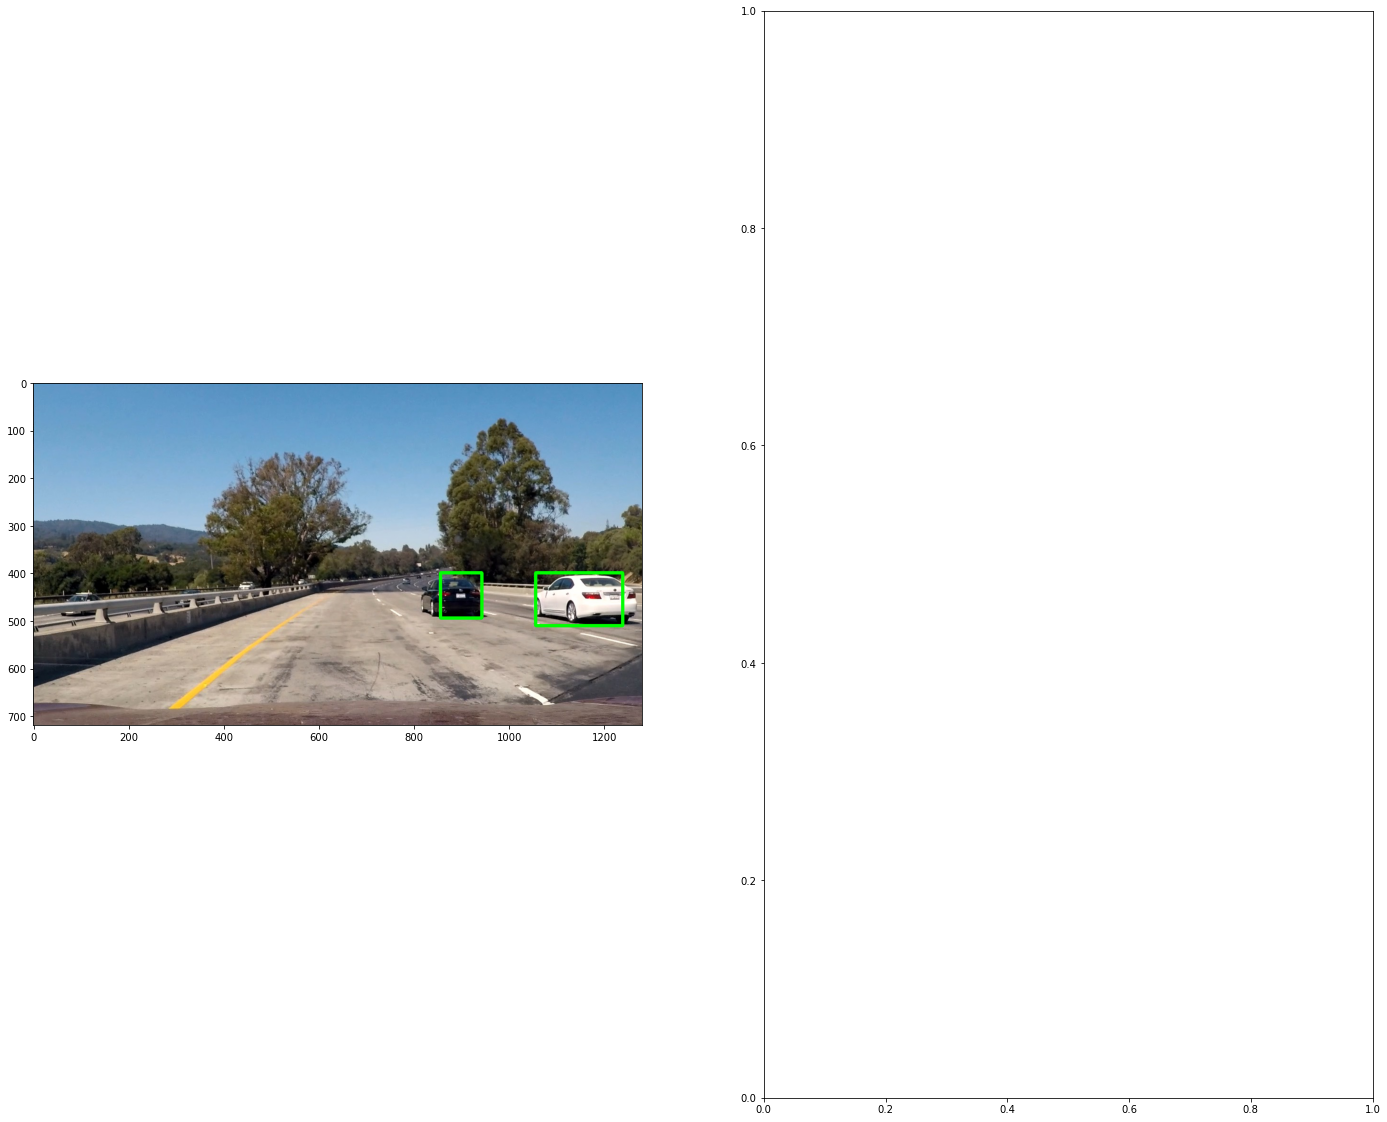

In [19]:
input_image(test_images[0],1)

test


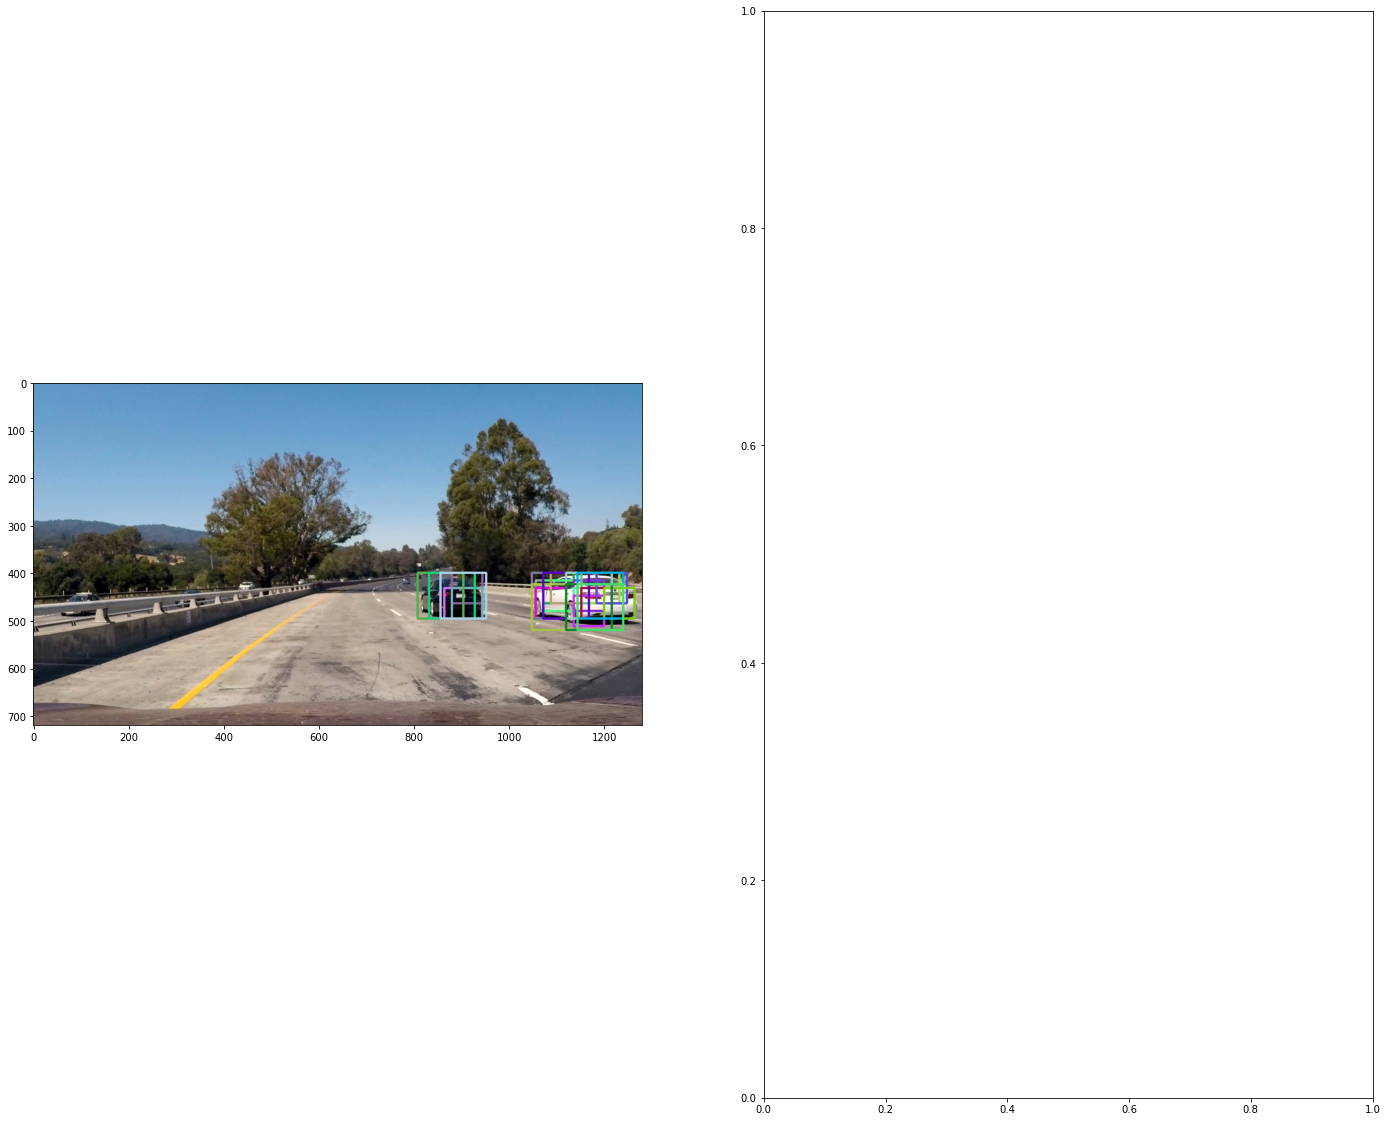

In [20]:
input_image(test_images[0],2)

In [21]:

class DetectionInfo():
    def __init__(self):
        self.max_size = 10
        self.old_bboxes = queue.Queue(self.max_size)
        self.heatmap = np.zeros_like(test_images[0][:, :, 0])

    def get_heatmap(self):
        self.heatmap = np.zeros_like(test_images[0][:, :, 0])
        if self.old_bboxes.qsize() == self.max_size:
            for bboxes in list(self.old_bboxes.queue):
                self.heatmap = add_heat(self.heatmap, bboxes)
                # self.heatmap = apply_threshold(self.heatmap, 2)
            self.heatmap = apply_threshold(self.heatmap, 20)
        return self.heatmap

    def get_labels(self):
        return label(self.get_heatmap())

    def add_bboxes(self, bboxes):
        if len(bboxes) < 1:
            return
        if self.old_bboxes.qsize() == self.max_size:
            self.old_bboxes.get()
        self.old_bboxes.put(bboxes)


def find_vehicles(image):
    bboxes = get_rectangles(image)
    detection_info.add_bboxes(bboxes)
    labels = detection_info.get_labels()
    if len(labels) == 0:
        result_image = image
    else:
        bboxes, result_image = draw_labeled_bboxes(image, labels)

    return result_image


detection_info = DetectionInfo()
detection_info.old_heatmap = np.zeros_like(test_images[0][:, :, 0])

def process_video(video):
 project_video_path = video
 project_video_output = 'output.mp4'

 #project_video = VideoFileClip(project_video_path)
 project_video = VideoFileClip(project_video_path).subclip(5,30)
 white_clip = project_video.fl_image(find_vehicles)  # NOTE: this function expects color images!!

 white_clip.write_videofile(project_video_output, audio=False)


In [22]:
process_video('video.mp4')

Moviepy - Building video output.mp4.
Moviepy - Writing video output.mp4



Moviepy - Done !
Moviepy - video ready output.mp4
